# Prepoznavanje oblika

Autor: Djordje Marjanovic 2016/0120

## Zadatak 1

Za bazu rukom pisanih samoglasnika, koja je dostupna na sajtu predmeta*
isprojektovati inovativni sistem za prepoznavanje cifara zasnovan na
testiranju hipoteza. Rezultate prikazati u obliku matrice konfuzije. Izveštaj
treba da sadrži kratki opis isprojektovanog sistema, obrazložen izbor
obeležja, kao i karakteristične primere pravilno i nepravilno klasifikovanih
slova.

### Postavka

In [165]:
%reset -f

import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

# DO NOT MODIFY
dataset_dir = "data/Slova/"
dataset_size_per_letter = 120

labels = ['A', 'E', 'I', 'O', 'U']
train_set_size_per_letter = 60
val_set_size_per_letter = 40
test_set_size_per_letter = 20

### Učitavanje podataka

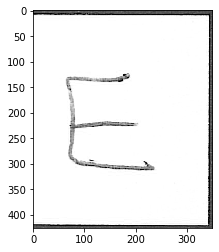

In [166]:
def load_sample(label, idx):
    return cv2.imread("{}baza{}{:03d}.bmp".format(dataset_dir, label, idx))

def load_set(indices):
    ret_set = []
    for label in labels:
        for idx in indices:
            ret_set.append((label, load_sample(label, idx)))
    return ret_set

def example_set(size):
    return [
        (label, load_sample(label, idx))
        for label, idx in [(
            random.choice(labels),
            random.randint(
                    1, dataset_size_per_letter - test_set_size_per_letter
                )
        ) for i in range(size)]
    ]
            
def load_train_val_test_sets(train_size, val_size):
    indices = list(range(1, train_size + val_size + 1))
    random.shuffle(indices)
    
    train = load_set(indices[:train_size])
    val = load_set(indices[train_size:])
    
    first_test_index = dataset_size_per_letter - test_set_size_per_letter + 1
    test = load_set(range(first_test_index, dataset_size_per_letter + 1))
    
    return train, val, test

sample_example = load_sample(
        random.choice(labels), 
        random.randint(1, 120 - test_set_size_per_letter)
    )

plt.imshow(sample_example)
# plt.title("Example of a raw dataset image")
plt.savefig('example.svg')
plt.show()

# train_set, val_set, test_set = load_train_val_test_sets(80, 20, 20)
# 
# random_point_index = random.randint(0, len(train_set))
# print(random_point_index)
# 
# random_point = train_set[random_point_index]
# plt.imshow(random_point[1])
# plt.title("Example of a raw dataset image")
# plt.show()

### Odsecanje ivica

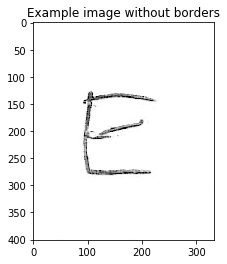

In [149]:
def crop_border(image, border=3):
    img = image[:, :, 0]
    
    search_area = int(0.1 * img.shape[0])
    edge = np.mean(1-img, axis=1) > 50
    if np.sum(edge[search_area::-1]) == 0:
        top = 0
    else:
        top = search_area - np.argmax(edge[search_area::-1])
    if np.sum(edge[-search_area:]) == 0:
        bottom = img.shape[0] - 1
    else:
        bottom = img.shape[0] - search_area + np.argmax(edge[-search_area:])
        
    search_area = int(0.1 * img.shape[1])
    edge = np.mean(1-img, axis=0) > 50
    if np.sum(edge[search_area::-1]) == 0:
        left = 0
    else:
        left = search_area - np.argmax(edge[search_area::-1])
    if np.sum(edge[-search_area:]) == 0:
        right = img.shape[1] - 1
    else:
        right = img.shape[1] - search_area + np.argmax(edge[-search_area:])

    return img[
           top + border: bottom - border,
           left + border: right - border
        ] / 256.0

sample_example = crop_border(sample_example)

plt.imshow(sample_example, cmap='gray')
plt.title("Example image without borders")
plt.show()

# random_point = train_set[13]
# plt.imshow(random_point[1], cmap='gray')
# # plt.show()
# I = crop_border(random_point[1], border=5)
# # plt.imshow(crop_border(random_point[1][0]), cmap='gray')
# plt.xlim(-10, random_point[1].shape[1] + 10)
# plt.ylim(random_point[1].shape[0] + 10, -10)
# plt.show()
# 
# plt.imshow(I < 0.9)
# plt.xlim(-10, I.shape[1] + 10)
# plt.ylim(I.shape[0] + 10, -10)
# plt.show()

In [150]:
# border_size = 30
# train_set = [(
#     label,
#     crop_border(sample)
# ) for label, sample in train_set]
# 
# val_set = [(
#     label,
#     crop_border(sample)
# ) for label, sample in val_set]
# 
# test_set = [(
#     label,
#     crop_border(sample)
# ) for label, sample in test_set]
# 
# random_point = train_set[random_point_index]
# plt.imshow(random_point[1], cmap = 'gray')
# plt.title("Removed borders")
# plt.show()

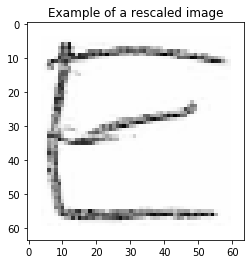

In [151]:
# TODO: split to crop_letter and rescale image 
def crop_letter(image: np.ndarray):
    from scipy.ndimage.morphology import binary_erosion, binary_dilation
    binary_threshold = 0.9
    erosion_size = 5
    padding = 4
    final_size = (64, 64)
    
    binary_image = 1.0 * image < binary_threshold
    binary_image = binary_erosion(
        binary_image, 
        structure = np.ones((erosion_size, erosion_size))
    )
    binary_image = binary_dilation(
        binary_image, 
        structure = np.ones((erosion_size, erosion_size))
    )
    
    x, y = np.meshgrid(range(image.shape[1]), range(image.shape[0]))
    x = x * binary_image
    y = y * binary_image
    
    u_bound = max(0, np.min(y[np.nonzero(y)]) - erosion_size)
    b_bound = min(image.shape[0] - 1, y.max() + erosion_size + 1)
    l_bound = max(0, np.min(x[np.nonzero(x)]) - erosion_size)
    r_bound = min(image.shape[1] - 1, x.max() + erosion_size + 1)
    
    cropped_image = image[u_bound: b_bound, l_bound: r_bound]
    resized_image = cv2.resize(
        src = cropped_image,
        dsize = (final_size[1] - 2 * padding, final_size[0] - 2 * padding)
    )
    
    final_image = np.ones(final_size)
    final_image[
        padding: final_size[0] - padding,
        padding: final_size[1] - padding
    ] = resized_image
    
    return 1 - final_image

sample_example = crop_letter(sample_example)

plt.imshow(1 - sample_example, cmap='gray')
plt.title("Example of a rescaled image")
plt.show()

# plt.imshow(train_set[38 * 9 + 6][1])
# plt.show()
# plt.imshow(crop(train_set[38 * 9 + 6][1]))
# plt.show()

# train_set = [(label, crop_letter(sample)) for label, sample in train_set]
# val_set = [(label, crop_letter(sample)) for label, sample in val_set]
# test_set = [(label, crop_letter(sample)) for label, sample in test_set]
# 
# random_point = train_set[random_point_index]
# fig, ax = plt.subplots(figsize=(15, 15))
# plt.imshow(random_point[1], cmap = 'gray')
# plt.title("Cropped image")
# plt.show()

### Celokupna obrada slike

In [152]:
def process_image(img: np.ndarray):
    return crop_letter(crop_border(img))

### Odsecanje nad podacima

In [153]:
def preprocess_set(raw_set: list):
    return [
        (label, process_image(image))
        for label, image in raw_set
    ]

### Funkcija za vizuelizaciju

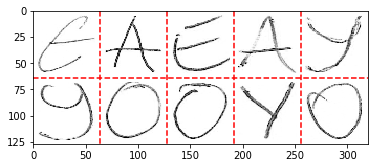

In [154]:
def display_square(imgs: list, n: int, m: int):
    w, h = imgs[0].shape
    comb = np.zeros((h * n, w * m))
    for i in range(n):
        for j in range(m):
            comb[i * h: (i + 1) * h, j * w: (j + 1) * w] = imgs[i * m + j]
    plt.imshow(comb, cmap = 'gray')
    for i in range(1, n):
        plt.plot([0, m * w], [i * h, i * h], '--r')
    for j in range(1, m):
        plt.plot([j * w, j * w], [0, n * h - 1], '--r')
    plt.xlim(0, w * m)
    plt.ylim(h * n - 1, 0)

display_square([
        1 - process_image(sample[1])
        for sample in example_set(10)],
        2, 5
    )
plt.show()

In [155]:
# @interact(image_id = (0, len(train_set) // 9))
# def example(image_id=0):
#     fig, ax = plt.subplots(figsize=(10, 10))
#     start = image_id * 9
#     end = start + 9
#     display_square([img for label, img in train_set[start: end]], 3, 3)
#     plt.show()

### Vestacko povecanje baze

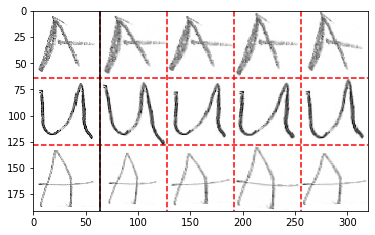

In [156]:
def generate_augmented_image(image: np.ndarray, variance: float = 0.3):
    translate_to_center = np.eye(3)
    translate_to_center[:2, 2] = -np.array(image.shape).T / 2

    translate_from_center = np.eye(3)
    translate_from_center[:2, 2] = np.array(image.shape).T / 2

    affine = np.zeros((3, 3))
    affine[:2, :2] = np.eye(2) + (np.random.rand(2, 2) - 0.5) * variance
    affine[2, :] = np.array([0, 0, 1])
    affine[:2, 2] = (np.random.rand(2) - 0.5) * variance

    final = translate_from_center.dot(affine.dot(translate_to_center)) 
    
    return cv2.warpPerspective(image, final, image.shape, borderValue=0)

display_square(sum([
            [1 - img] + [1 - generate_augmented_image(img) for j in range(4)]
            for img in [process_image(sample[1]) for sample in example_set(3)]
        ], []),
        3, 5
    )
plt.plot([64, 64], [0, 64 * 3], '-k')
plt.show()

### Karakteristike

In [157]:
import features

def create_feature_vector(features: list, raw_set: list):
    return np.array([
        [labels.index(label)] + [
            feature.get_feature(sample) for feature in features
        ]
        for label, sample in raw_set
    ])

# TODO: features.IntegralImage()
example_features = [
    features.Stack([
        features.RectSelect(20, 43, 20, 43),
        features.Mean()
    ]),
    features.Stack([
        features.RectSelect(0, 63, 0, 63),
        features.Mean()
    ])
]

example_feature_vector = create_feature_vector(
        example_features, [
            (label, process_image(img)) for label, img in example_set(100)
        ]
    ) 

# X = np.array([
#     [letters.index(letter)] + [
#         feature.get_feature(sample)
#         for feature in selected_features
#     ]
#     for letter, sample in train_set
# ])
# 
# X_test = np.array([
#     [letters.index(letter)] + [
#         feature.get_feature(sample)
#         for feature in selected_features
#     ]
#     for letter, sample in val_set
# ])
# 
# print(selected_features[0].get_feature(random_point[1]))

### Vizuelizacija karakteristika

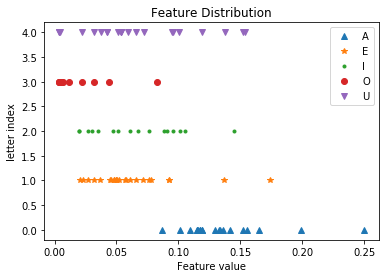

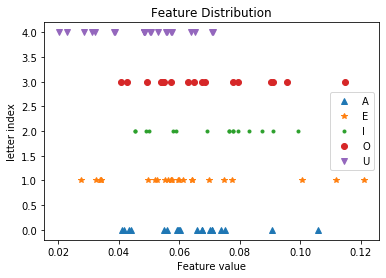

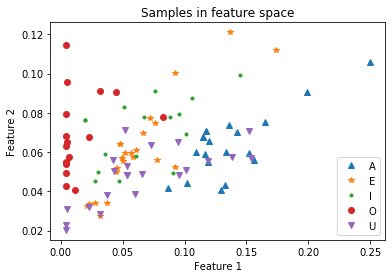

In [158]:
letter_to_symbol = {
    'A': '^',
    'E': '*',
    'I': '.',
    'O': 'o',
    'U': 'v',
}


def feature_distribution(X: np.ndarray, feature_id: int):
    for label_id in range(len(labels)):
        values = X[X[:, 0] == label_id][:, feature_id + 1]
        plt.plot(
            values,
            np.ones(values.shape[0]) * label_id,
            letter_to_symbol[labels[label_id]]
        )
    plt.legend(labels)
    plt.title('Feature Distribution')
    plt.xlabel('Feature value')
    plt.ylabel('letter index')
    plt.show()


def compare_features(X: np.ndarray, feature1_id: int = 0, feature2_id: int = 1):
    for label_id in range(len(labels)):
        feature_for_label_id = X[X[:, 0] == label_id] 
        plt.plot(
            feature_for_label_id[:, feature1_id + 1],
            feature_for_label_id[:, feature2_id + 1],
            letter_to_symbol[labels[label_id]]
        )
    plt.legend(labels)
    plt.title("Samples in feature space")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

feature_distribution(example_feature_vector, 0)
feature_distribution(example_feature_vector, 1)
compare_features(example_feature_vector)

# feature_distribution(4)
# compare_features(3, 4)
    

### Estimator distribucija

In [159]:
def estimate_normal(X: np.ndarray):
    M = np.array([
        np.mean(X[X[:, 0] == letter_id], axis=0)
        for letter_id in range(len(labels))
    ])[:, 1:]
    
    S = np.array([
        np.cov(X[X[:, 0] == letter_id][:, 1:].T)
        for letter_id in range(len(labels))
    ])
    return M, S

example_M, example_S = estimate_normal(example_feature_vector)
print("M =", example_M)
print("S =", example_S)

M = [[0.13562486 0.06393061]
 [0.06203748 0.06102884]
 [0.06633829 0.07032657]
 [0.01388517 0.06783498]
 [0.06604859 0.04804442]]
S = [[[0.00133361 0.00044855]
  [0.00044855 0.00025919]]

 [[0.00121565 0.00072635]
  [0.00072635 0.00055674]]

 [[0.00131522 0.00032421]
  [0.00032421 0.00029235]]

 [[0.0004251  0.00012698]
  [0.00012698 0.00040169]]

 [[0.00206265 0.00047274]
  [0.00047274 0.00021075]]]


### Testiranje hipoteza

In [160]:
def bayesian_inference(M, S, X_test):
    q = [
        scipy.stats.multivariate_normal(
                mean=M[letter_id],
                cov=S[letter_id]
            ).pdf(
                X_test[:, 1:]
            )
        for letter_id in range(len(labels))
    ]
    
    q = np.array(q)
    
    pred = np.argmax(q, axis=0)
    confusion_matrix = np.zeros((len(labels), len(labels)))
    for i in range(X_test.shape[0]):
        confusion_matrix[int(X_test[i, 0]), pred[i]] += 1
    
    accuracy = np.sum(np.diagonal(confusion_matrix)) / np.sum(confusion_matrix)
    return accuracy, confusion_matrix

example_accuracy, example_confusion_matrix = \
    bayesian_inference(example_M, example_S, example_feature_vector)
        
print(end='\t')
for letter in labels:
    print(letter, end='\t')
print()    
for i, letter in enumerate(labels):
    print(letter, end='\t')
    for j in range(len(labels)):
        print(example_confusion_matrix[i][j], end='\t')
    print()
print()
print("accuracy =", example_accuracy)

	A	E	I	O	U	
A	19.0	0.0	0.0	0.0	1.0	
E	0.0	15.0	5.0	0.0	4.0	
I	0.0	7.0	6.0	2.0	1.0	
O	0.0	1.0	0.0	17.0	0.0	
U	5.0	9.0	1.0	0.0	7.0	

accuracy = 0.64


### Optimizacija karakteristika

Execution time:

not parallel: 28.5

1 process:   27.4

2 processes: 15.3

4 processes: 9.4

**8 processes: 7.9**

16 processes: 7.1

In [161]:
def model_from_vector(vector: np.ndarray):
    return [
        features.Stack([
            features.RectSelect(
                vector[4 * i],
                vector[4 * i + 1],
                vector[4 * i + 2],
                vector[4 * i + 3]
            ), 
            features.Mean()
        ])
        for i in range(len(vector) // 4)
    ]

def evaluate_model(model, evaluation_set, k_fold: bool = True, val_set: list = None): 
    
    if sum(model[1::2] - model[::2] < 10) != 0:
        return -1
    
    selected_features = model_from_vector(model)
    
    if k_fold:
        k_fold_cross_val = 5
        samples_per_fold = len(evaluation_set) // len(labels) // k_fold_cross_val
        
        randomized_set = [
            [(label, sample[1]) for sample in evaluation_set if sample[0] == label]
            for label in labels
        ]
        
        for i in range(len(randomized_set)):
            random.shuffle(randomized_set[i])
    
        split_sets = [
            sum([
                [randomized_set[i][j]]
                for j in range(k * samples_per_fold, (k + 1) * samples_per_fold) 
                for i in range(len(labels))
            ], [])
            for k in range(k_fold_cross_val)
        ]
    else: 
        k_fold_cross_val = 1
        split_sets = None
        
    average_accuracy = 0
    
    for k in range(k_fold_cross_val):
        if k_fold:
            train_set = sum(split_sets[:k] + split_sets[k+1:], [])
            val_set = split_sets[k]
        else:
            train_set = evaluation_set
            
        X = create_feature_vector(selected_features, train_set)
        X_val = create_feature_vector(selected_features, val_set)
        
        M, S = estimate_normal(X)
        try:
            accuracy, confusion_matrix = bayesian_inference(M, S, X_val)
            average_accuracy += accuracy
        except:
            average_accuracy -= k_fold_cross_val
    
    return average_accuracy / k_fold_cross_val


def process_model(args):
    import traceback
    try:
        model, eval_set, val_set, queue, lock, k_fold = args
        
        fitness = evaluate_model(model, eval_set, k_fold=k_fold, val_set=val_set)
        
        lock.acquire()
        queue.append((fitness, model))
        lock.release()
    except:
        traceback.print_exc()
        raise
    
    
def select_best_models(
        models: np.ndarray,
        evaluation_set: list,
        selection_rate: float = 0.5,
        thread_count: int = 8,
        k_fold: bool = True,
        val_set: list = None):
    
    import warnings
    warnings.filterwarnings("ignore")
    
    if thread_count > 1:
        import multiprocessing as mp
    
        queue_lock = mp.Manager().Lock()
        model_queue = mp.Manager().list()
        
        pool = mp.Pool(processes = 8)
        pool.map(process_model, [
            (model, evaluation_set, val_set, model_queue, queue_lock, k_fold) for model in models
        ])
    
        pool.close()
        pool.join()
    
        return np.array([
            model for fitness, model in sorted(
                model_queue,
                key = lambda pair: -pair[0]
            )[:int(selection_rate * models.shape[0])]
        ])
    else:
        return np.array([
                model for fitness, model in sorted([
                    (evaluate_model(model, evaluation_set), model)
                    for model in models
                ],
                key = lambda pair: -pair[0])
                [:int(selection_rate * models.shape[0])]
            ])


def crossover(models, final_count = 100):
    parent_indices = np.random.randint(
        models.shape[0],
        size = final_count - models.shape[0]
    )
    
    parents = models[parent_indices]
    shuffled_parents = parents.copy()
    np.random.shuffle(shuffled_parents)
    selection = np.random.rand(*parents.shape) < 0.5
    
    parents = np.concatenate([
        parents,
        shuffled_parents
    ], axis=0)
    selection = np.concatenate([
        selection,
        1 - selection
    ], axis=0)
    
    children = parents * selection
    child_count = parents.shape[0] // 2
    
    return np.concatenate([
            models,
            children[: child_count, :] + children[child_count:,:]
        ], axis=0) 
    

def mutate(
        models,
        randomization_rate : float = 0.01,
        shift_rate : float = 0.05):
    randomization_select = np.random.rand(*models.shape) < randomization_rate
    shift_select = np.random.rand(*models.shape) < shift_rate
    randomization_select[0, :] = 0
    shift_select[0, :] = 0
    
    return (models * (1 - randomization_select) +
        randomization_select * np.random.rand(*models.shape) * 64 +
        shift_select * (np.random.randn(*models.shape) * 3)).astype(int)


def initialize(param_count: int = 20, population_count: int = 100):
    v1 = (np.random.rand(population_count, param_count // 2) * 32)
    v2 = (np.random.rand(population_count, param_count // 2) * 32)
    v_combined = np.zeros((v1.shape[0], v1.shape[1] + v2.shape[1]))
    v_combined[:, ::2] = v1
    v_combined[:, 1::2] = v2 + 32
    return v_combined.astype(int)

In [162]:
def evolution_optimization(trai_set: list, val_set: list):
    
    import time
    start_time = time.time()

    models = initialize(population_count = 100)
    models = select_best_models(models, train_set, selection_rate = 0.2)
    
    for k in range(5):
        print("Iteration {}:".format(k))
        models = crossover(models, final_count=100)
        models = mutate(models, shift_rate = 0.1 / (k + 1))
        models = select_best_models(models, train_set, selection_rate = 0.4)
        
        print("Accuracy: {:.03f}".format(evaluate_model(models[0], train_set, k_fold=False, val_set=val_set)))
    
    print("Execution time: {:.03f}".format(time.time() - start_time))
    
    return models

dataset = load_train_val_test_sets(80, 20)
dataset = (preprocess_set(set) for set in dataset)
train_set, val_set, test_set = dataset
train_set = sum([
        [(label, image)] + [(label, generate_augmented_image(image)) for j in range(2)]
        for label, image in train_set
    ], [])
models = evolution_optimization(train_set, val_set)

Iteration 0:
Accuracy: 0.860
Iteration 1:
Accuracy: 0.860
Iteration 2:
Accuracy: 0.860
Iteration 3:
Accuracy: 0.940
Iteration 4:
Accuracy: 0.940
Execution time: 31.430


### Izabrane karakteristike

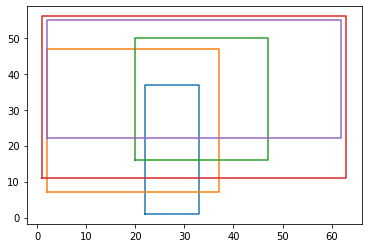

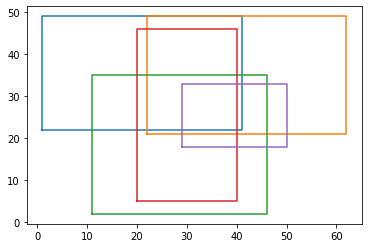

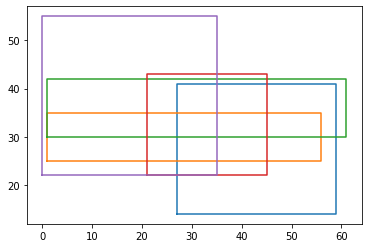

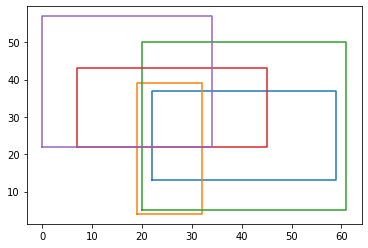

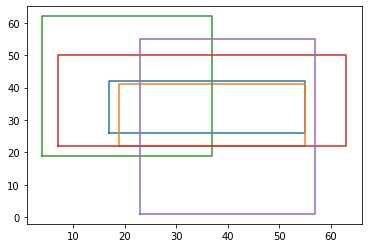

In [163]:
for model_id in range(5):
    for i in range(models.shape[1] // 4):
        top = models[model_id, 4 * i]
        bottom = models[model_id, 4 * i + 1]
        left = models[model_id, 4 * i + 2]
        right = models[model_id, 4 * i + 3]
        
        plt.plot(
            [left, right, right, left, left],
            [top, top, bottom, bottom, top]
        )
    plt.show()

### Greske

In [164]:
selected_features = model_from_vector(models[0])

X = create_feature_vector(selected_features, train_set)
X_test = create_feature_vector(selected_features, test_set)

M, S = estimate_normal(X)

accuracy, confusion_matrix = bayesian_inference(M, S, X_test)
    
print(end='\t')
for letter in labels:
    print(letter, end='\t')
print()    
for i, letter in enumerate(labels):
    print(letter, end='\t')
    for j in range(len(labels)):
        print(confusion_matrix[i][j], end='\t')
    print()
print()
print("accuracy =", accuracy)

	A	E	I	O	U	
A	15.0	2.0	0.0	0.0	3.0	
E	5.0	15.0	0.0	0.0	0.0	
I	2.0	1.0	17.0	0.0	0.0	
O	0.0	0.0	0.0	20.0	0.0	
U	1.0	0.0	0.0	0.0	19.0	

accuracy = 0.86


## Zadatak 2

Po ugledu na primer 4.3 iz dokumenta Predavanje 2**, generisati po N=500 odbiraka iz dveju dvodimenzionih klasa.

1. Na dijagramu prikazati odbirke.

2. Generisati geometrijsko mesto tačaka sa konstantnom vrednošću funkcija gustina verovatnoće pa ih prikazati na dijagramu u prostoru oblika.

3. Isprojektovati Bajesov klasifikator minimalne greške i na dijagramu, zajedno sa odbircima, skicirati klasifikacionu liniju, pa proceniti verovatnoću greške.

4. Ponoviti prethodnu tačku za neki drugi klasifikator po izboru.

5. Za klase oblika generisanih u prethodnim tačkama, isprojektovati Wald-ov sekvencijalni test pa skicirati zavisnost broja potrebnih odbiraka od usvojene verovatnoće grešaka prvog, odnosno drugog tipa.

6. Izveštaj treba da sadrži tekst zadatka, elemente teorije, zahtevane ilustracije, dijagrame sa odgovarajućim komentarima. Domaći zadaci se brane zbirno a ne pojedinačno, i na odbranu domaćih zadataka treba poneti odštampani izveštaj.

### Postavka

In [ ]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats
import IPython.display
import ipywidgets
import time
import threading

matplotlib.rc('text', usetex=True)

### Pomoćne funkcije

In [ ]:
def f_contour(f, x, y, threshold=0, color=None, label_position=None, label=None, linestyle='solid'):    
    contour = ax.contour(x, y, f, levels=[threshold], colors=color, linestyles=linestyle)
    if label_position is None:
        manual = None
    else:
        manual = [label_position]
        
    if label is not None:
        ax.clabel(contour, inline=1, fontsize=10, colors=color, fmt={threshold:label}, manual=manual)

def pdf_contour(f, x, y, thresholds=(0.3, 0.7), color=None, label_positions=None, f_name='f'):
    if label_positions is None:
        label_positions = [None] * len(thresholds)
    f_max = np.max(f)
        
    for threshold, label_position in zip(thresholds, label_positions):
        f_contour(f, x, y, threshold * f_max, color, label_position=label_position, label='$' + str(threshold) + f_name + '_{max}$')

def decision_contour(f, x, y, color=None, label_position=None, label=None, f_name='h'):
    f_contour(f, x, y, color=color, label_position=label_position, label=label, linestyle='dashed')
    

### Definisanje distribucija

In [ ]:
x_space = np.linspace(-4, 12, 1000)
y_space = np.linspace(-10, 8, 1000)
x, y = np.meshgrid(x_space, y_space)
pos = np.dstack((x, y))

p11 = 0.6
n11 = scipy.stats.multivariate_normal([1, 1], [[4, 1.1], [1.1, 2]])
p12 = 1 - p11
n12 = scipy.stats.multivariate_normal([6, 4], [[3, -0.8], [-0.8, 1.5]])
p21 = 0.55
n21 = scipy.stats.multivariate_normal([7, -4], [[2, 1.1], [1.1, 4]])
p22 = 1 - p21
n22 = scipy.stats.multivariate_normal([6, 0], [[3, 0.8], [0.8, 0.5]])

def f1(x):
    return p11 * n11.pdf(x) + p12 * n12.pdf(x)

def f2(x):
    return p21 * n21.pdf(x) + p22 * n22.pdf(x)

### 2.1
Na dijagramu prikazati odbirke.

In [ ]:
N = 500

select = np.random.rand(N, 1) < p11
samples_w1 = n11.rvs(N) * select + n12.rvs(N) * (1 - select)

select = np.random.rand(N, 1) < p21
samples_w2 = n21.rvs(N) * select + n22.rvs(N) * (1 - select)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

plt.scatter(samples_w1[:, 0], samples_w1[:, 1], alpha=0.6)
plt.scatter(samples_w2[:, 0], samples_w2[:, 1], alpha=0.6)

ax.set_aspect('equal')
plt.xlim(-4, 12)
plt.ylim(-10, 8)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend([r'$\omega_1$', r'$\omega_2$'])

plt.show()

### 2.2
Generisati geometrijsko mesto tačaka sa konstantnom vrednošću funkcija gustina verovatnoće pa ih prikazati na dijagramu u prostoru oblika.

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

pdf_contour(f1(pos), x, y, thresholds=(0.3, 0.6, 0.8), color='C0')
pdf_contour(f2(pos), x, y, thresholds=(0.05, 0.2, 0.8), color='C1')

ax.set_aspect('equal')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.savefig('a.svg')
plt.show()

### 2.3
Isprojektovati Bajesov klasifikator minimalne greške i na dijagramu, zajedno sa odbircima, skicirati klasifikacionu liniju, pa proceniti verovatnoću greške.

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

plt.scatter(samples_w1[:, 0], samples_w1[:, 1], alpha=0.3)
plt.scatter(samples_w2[:, 0], samples_w2[:, 1], alpha=0.3)

h = -np.log(f1(pos)) + np.log(f2(pos))

decision_contour(h, x, y, color='C2', label=r'$h(\mathbf{x})=-\ln\mu$', label_position=(0, -5))

ax.set_aspect('equal')
plt.xlim(-4, 12)
plt.ylim(-10, 8)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend([r'$\omega_1$', r'$\omega_2$'])

plt.show()

h_w1 = -np.log(f1(samples_w1)) + np.log(f2(samples_w1))
h_w2 = -np.log(f1(samples_w2)) + np.log(f2(samples_w2))
e1 = np.sum(1.0 * h_w1 > 0) / N
e2 = np.sum(1.0 * h_w2 < 0) / N
print("Aproksimativna verovatnoće greške: {}%".format((e1 + e2) / 2 * 100))

### 2.4
Ponoviti prethodnu tačku za neki drugi klasifikator po izboru.

In [ ]:
h = -np.log(f1(samples)) + np.log(f2(samples))

H, t = np.histogram(h, bins=1000, density = True)

plt.bar(t[:-1], H / N)
plt.xlabel('$h$')
plt.ylabel(r'$f_{h}(h|\omega_2)$')
plt.show()

T = (t[:-1] + t[1:]) / 2
diffs = t[1:] - t[:-1]

H = np.cumsum(H) * diffs

e0 = 0.05

min_index = np.argmin(np.abs(e0 - H)) 
mint = T[min_index]

plt.plot(T, H)
plt.xlim(np.min(T), np.max(T))
plt.ylim(0, 1)
plt.text(10, 0.2, '$\\mu=' + "{:.04f}".format(np.exp(-mint)) + '$')
plt.plot([-10, mint], [e0, e0], '--k')
plt.plot([mint, mint], [0, e0], '--k')
plt.plot([mint], [e0], 'ok')
plt.xlabel(r'$-\ln\mu$')
plt.ylabel(r'$\varepsilon_0$')
plt.show()

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

plt.scatter(samples_w1[:, 0], samples_w1[:, 1], alpha=0.3)
plt.scatter(samples_w2[:, 0], samples_w2[:, 1], alpha=0.3)

h = -np.log(f1(pos)) + np.log(f2(pos))
h -= mint

decision_contour(h, x, y, color='C2', label=r'$h(\mathbf{x})=-\ln\mu$', label_position=(0, -5))

ax.set_aspect('equal')
plt.xlim(-4, 12)
plt.ylim(-10, 8)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend([r'$\omega_1$', r'$\omega_2$'])

plt.show()

h_w1 = -np.log(f1(samples_w1)) + np.log(f2(samples_w1))
h_w2 = -np.log(f1(samples_w2)) + np.log(f2(samples_w2))
h_w1 -= mint
h_w2 -= mint
e1 = np.sum(1.0 * h_w1 > 0) / N
e2 = np.sum(1.0 * h_w2 < 0) / N
print("Aproksimativna verovatnoće greške prve vrste: {:.01f}%".format(e1 * 100))
print("Aproksimativna verovatnoće greške druge vrste: {:.01f}%".format(e2 * 100))

### 2.5
Za klase oblika generisanih u prethodnim tačkama, isprojektovati Wald-ov sekvencijalni test pa skicirati zavisnost broja potrebnih odbiraka od usvojene verovatnoće grešaka prvog, odnosno drugog tipa.

In [ ]:
def wald(e1 = 1e-4, e2 = 1e-5, visualize = False, only_first = True):
    a = np.log(e2) - np.log(1 - e1)
    b = np.log(1 - e2) - np.log(e1)

    N = 10

    def experiment(w = 1):
        if w == 2:
            select = np.random.rand(N, 1) < p21
            samples = n21.rvs(N) * select + n22.rvs(N) * (1 - select)
        else:
            select = np.random.rand(N, 1) < p11
            samples = n11.rvs(N) * select + n12.rvs(N) * (1 - select)


        h = -np.log(f1(samples)) + np.log(f2(samples))

        s = np.cumsum(h)

        if np.sum(1.0 * (s < a)) > 0:
            return s[:np.argmax(1.0 * (s < a)) + 1]
        if np.sum(1.0 * (s > b)) > 0:
            return s[:np.argmax(1.0 * (s > b)) + 1]
        return s

    m = 0
    num_exp = 50

    for i in range(num_exp):
        s1 = experiment(1)
        s2 = experiment(2)
        if only_first:
            m += len(s1)
        else:
            m += len(s1) + len(s2)
        if visualize:
            plt.plot(range(1, len(s1) + 1), s1, 'C0', alpha = 0.6)
            plt.plot(range(1, len(s2) + 1), s2, 'C1', alpha = 0.6)

    m /= 2 * num_exp

    if visualize:
        print("average number of samples needed: {}".format(m))

        plt.plot([0, N-1], [a, a], '--k', alpha = 0.5)
        plt.plot([0, N-1], [b, b], '--k', alpha = 0.5)

        plt.xlabel(r'$m$')
        plt.ylabel(r'$s(m)$')
        plt.show()

    return m

wald_e1 = []
e1_range = np.logspace(-10, 0, 101)
for e1 in e1_range:
    wald_e1.append(wald(e1 = e1))
    
plt.semilogx(e1_range, wald_e1)
plt.show()

wald_e2 = []
e2_range = np.logspace(-10, 0, 101)
for e2 in e2_range:
    wald_e2.append(wald(e2 = e2))
    
plt.semilogx(e2_range, wald_e2)
plt.show()

## Zadatak 3 (Opcija 1)

Za bazu slika sanitarnih kuglica, koja je dostupna na sajtu predmeta* isprojektovati inovativni sistem za detekciju postojanja kuglice na slici i prepoznavanja boje u slučaju da kuglica postoji. Rezultate prikazati u obliku matrice konfuzije. Izveštaj treba da sadrži kratki opis isprojektovanog sistema, obrazložen izbor obeležja, kao i karakteristične primere pravilnog i nepravilnog rada klasifikatora.

### Postavka

In [83]:
%reset -f

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random

### Učitavanje baze

In [84]:
def load_class(folder_name):
    image_file_dirs = sorted(os.listdir(folder_name))
    dataset = []
    for image_file_dir in image_file_dirs:
        dataset.append(cv2.imread(folder_name + '/' + image_file_dir))
    return dataset

def load_dataset():
    dataset_dir = 'data/Kuglice/'
    class_folders = sorted(os.listdir(dataset_dir))
    dataset = {}
    for class_folder in class_folders:
        dataset[class_folder] = load_class(dataset_dir + class_folder)
    return dataset
    
dataset = load_dataset()

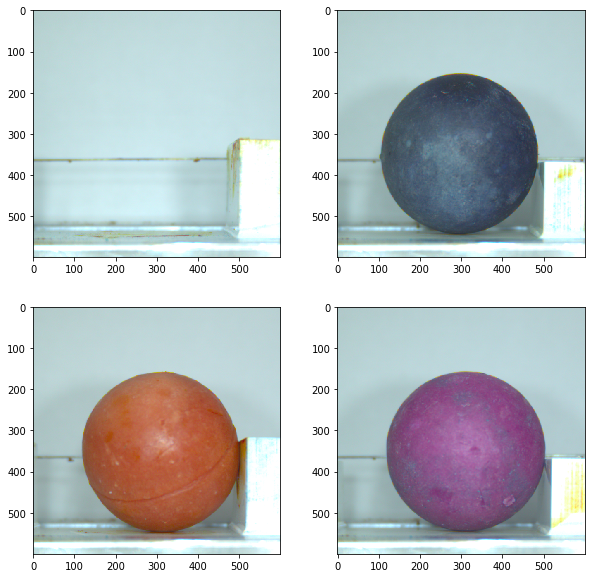

In [85]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
Cs = ['C{}'.format(x) for x in random.sample(range(10), 4)]
ax1.imshow(random.sample(dataset[Cs[0]], 1)[0])
ax2.imshow(random.sample(dataset[Cs[1]], 1)[0])
ax3.imshow(random.sample(dataset[Cs[2]], 1)[0])
ax4.imshow(random.sample(dataset[Cs[3]], 1)[0])
plt.show()

In [115]:
def extract_features(image):
    r = np.mean(image[200:550, 150:450, 0]) / 255
    g = np.mean(image[200:550, 150:450, 1]) / 255
    b = np.mean(image[200:550, 150:450, 2]) / 255
    return [r, g, b]

dataset_np = []

for c, images in dataset.items():
    for image in images:
        dataset_np.append([int(c[1])] + extract_features(image))

dataset_np = np.array(dataset_np)

### K-means

1


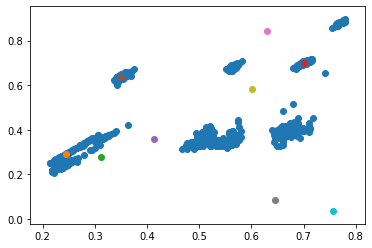

2


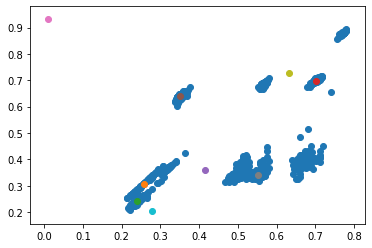

3


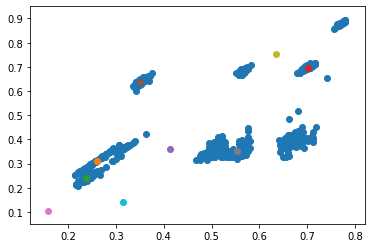

4


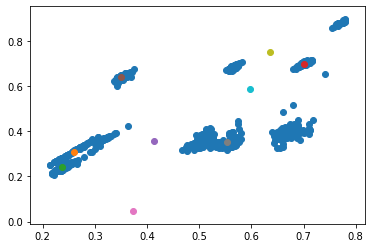

5


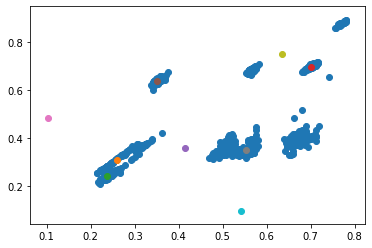

6


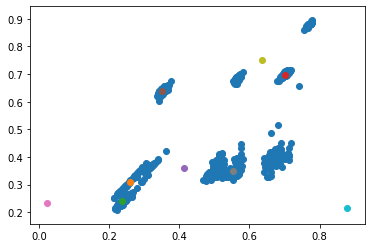

7


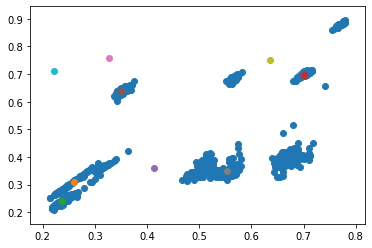

8


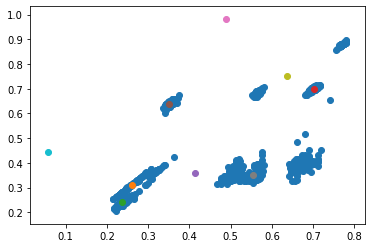

9


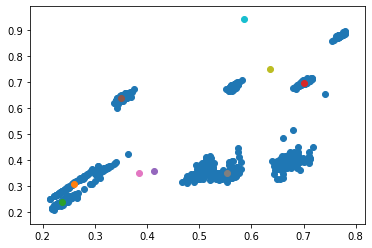

10


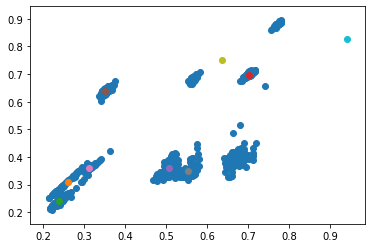

11


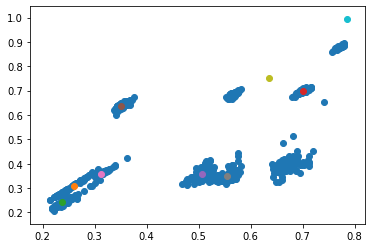

12


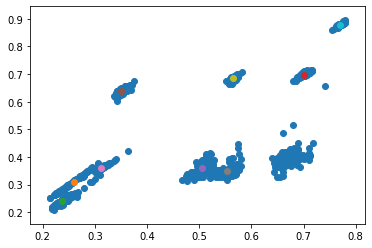

13


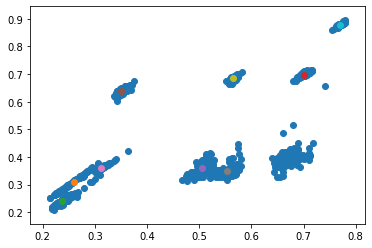

[[0.26013101 0.3089499  0.36723089]
 [0.23768971 0.24058892 0.23511454]
 [0.70128806 0.69728339 0.53066293]
 [0.50542534 0.3586902  0.9597221 ]
 [0.35071803 0.63841098 0.40234557]
 [0.31202804 0.35921142 0.9145985 ]
 [0.55368671 0.35053277 0.53861958]
 [0.56566441 0.6852534  0.9396846 ]
 [0.76998163 0.87829827 0.8867012 ]
 [0.66973869 0.39471763 0.27500576]]
[[0.26013101 0.3089499  0.36723089]
 [0.23768971 0.24058892 0.23511454]
 [0.70128806 0.69728339 0.53066293]
 [0.50542534 0.3586902  0.9597221 ]
 [0.35071803 0.63841098 0.40234557]
 [0.31202804 0.35921142 0.9145985 ]
 [0.55368671 0.35053277 0.53861958]
 [0.56566441 0.6852534  0.9396846 ]
 [0.76998163 0.87829827 0.8867012 ]
 [0.66973869 0.39471763 0.27500576]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1.

In [125]:
means = np.random.rand(10, 3)
X = dataset_np.copy()
old_means = means.copy()

mean_history = []

while True:
    old_means = means.copy()
    mean_history.append(old_means)
    print(len(mean_history))
    
    # Assign classes
    for x in X:
        shortest_distance = 2
        closest_class = -1
        for i, m in enumerate(means):
            dist = np.linalg.norm(x[1:] - m)
            if dist < shortest_distance:
                shortest_distance = dist
                closest_class = i
        x[0] = closest_class
    
    # Calculate new means
    new_means = np.zeros((10, 4))
    for x in X:
        new_means[int(x[0]), :-1] += x[1:]
        new_means[int(x[0]), -1] += 1
    for i, mean in enumerate(new_means):
        if mean[-1] == 0:
            means[i] = np.random.rand(3)
        else:
            means[i] = mean[:-1] / mean[-1]
    
    # Draw
    plt.scatter(X[:, 1], X[:, 2])
    for i in range(10):
        plt.scatter(means[i, 0], means[i, 1])
    plt.show()
    
    # End condition
    if np.sum(1.0 * (old_means == means)) == 30:
        print(old_means)
        print(means)
        print(old_means == means)
        print(1.0 * (old_means == means))
        print(np.sum(1.0 * (old_means == means)))
        break

In [126]:
means

array([[0.26013101, 0.3089499 , 0.36723089],
       [0.23768971, 0.24058892, 0.23511454],
       [0.70128806, 0.69728339, 0.53066293],
       [0.50542534, 0.3586902 , 0.9597221 ],
       [0.35071803, 0.63841098, 0.40234557],
       [0.31202804, 0.35921142, 0.9145985 ],
       [0.55368671, 0.35053277, 0.53861958],
       [0.56566441, 0.6852534 , 0.9396846 ],
       [0.76998163, 0.87829827, 0.8867012 ],
       [0.66973869, 0.39471763, 0.27500576]])

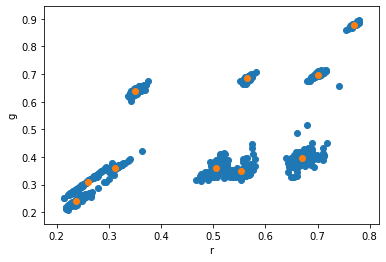

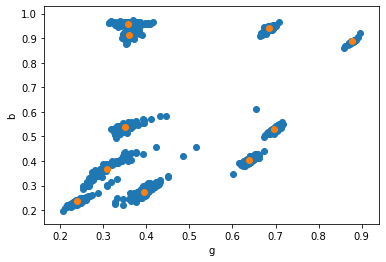

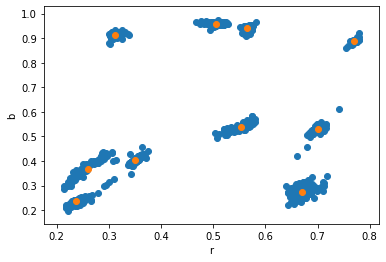

In [127]:
plt.scatter(X[:, 1], X[:, 2])
plt.scatter(means[:, 0], means[:, 1])
plt.xlabel('r')
plt.ylabel('g')
plt.show()
plt.scatter(X[:, 2], X[:, 3])
plt.scatter(means[:, 1], means[:, 2])
plt.xlabel('g')
plt.ylabel('b')
plt.show()
plt.scatter(X[:, 1], X[:, 3])
plt.scatter(means[:, 0], means[:, 2])
plt.xlabel('r')
plt.ylabel('b')
plt.show()

## Zadatak 4
1. Generisati po $N=500$ dvodimenzionih odbiraka iz četiri klase koje će biti linearno separabilne. Preporučujem da to budu Gausovski raspodeljeni dvodimenzioni oblici. Izabrati jednu od metoda za klasterizaciju (c mean metod, metod kvadratne dekompozicije, metod maksimalne verodostojnosti ili metod grana i granica) i primeniti je na formirane uzorke klasa. Izvršiti analizu osetljivosti izabranog algoritma na početnu klasterizaciju kao i srednji broj potrebnih iteracija. Takođe izvršiti analize slučaja kada se apriorno ne poznaje broj klasa.

2. Generisati po $N=500$ dvodimenzionih odbiraka iz dve klase koje su nelinearno separabilne. Izabrati jednu od metoda za klasterizaciju koje su primenjive za nelinearno separabilne klase (metod kvadratne dekompozicije ili metod maksimalne verodostojnosti) i ponoviti analizu iz prethodne tačke.

### Postavka

In [129]:
%reset -f

import matplotlib.pyplot as plt
import numpy as np
import random
import scipy

### Zadatak 4.1
### Generisanje podataka

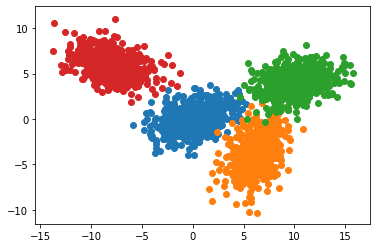

In [144]:
N = 500
X1 = scipy.stats.multivariate_normal([0, 0], [[4, 1], [1, 2]]).rvs(N)
X2 = scipy.stats.multivariate_normal([6, -4], [[2, 1], [1, 4]]).rvs(N)
X3 = scipy.stats.multivariate_normal([10, 4], [[4, 1], [1, 2]]).rvs(N)
X4 = scipy.stats.multivariate_normal([-8, 6], [[4, -1], [-1, 2]]).rvs(N)

plt.scatter(X1[:, 0], X1[:, 1])
plt.scatter(X2[:, 0], X2[:, 1])
plt.scatter(X3[:, 0], X3[:, 1])
plt.scatter(X4[:, 0], X4[:, 1])

1


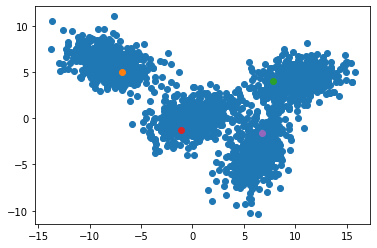

2


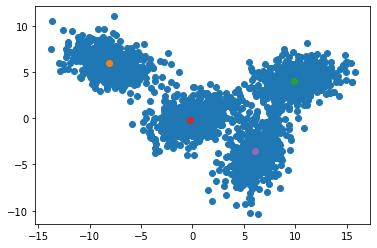

3


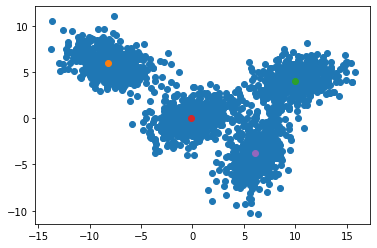

4


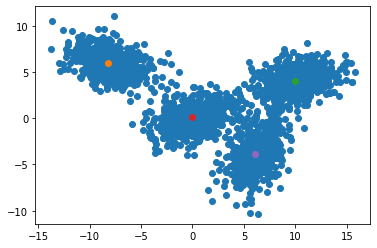

5


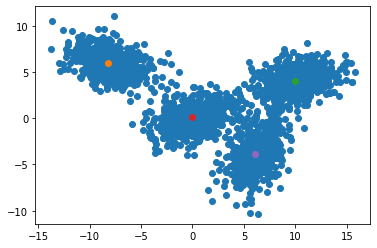

6


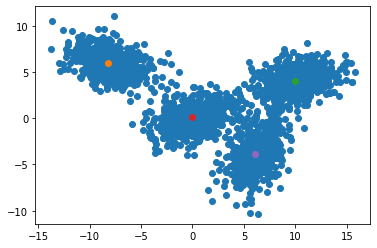

[[-8.18802989  6.00511235]
 [ 9.99513174  3.99241732]
 [-0.01982636  0.09893449]
 [ 6.11532689 -3.9075461 ]]
[[-8.18802989  6.00511235]
 [ 9.99513174  3.99241732]
 [-0.01982636  0.09893449]
 [ 6.11532689 -3.9075461 ]]
[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
8.0


In [146]:
means = np.random.rand(4, 2)
old_means = means.copy()
X = np.vstack([X1, X2, X3, X4])
y = np.vstack([np.zeros((N, 1)), np.ones((N, 1)), np.ones((N, 1)) * 2, np.ones((N, 1)) * 3])
X = np.hstack([y, X])

mean_history = []

while True:
    old_means = means.copy()
    mean_history.append(old_means)
    print(len(mean_history))
    
    # Assign classes
    for x in X:
        shortest_distance = 1000
        closest_class = -1
        for i, m in enumerate(means):
            dist = np.linalg.norm(x[1:] - m)
            if dist < shortest_distance:
                shortest_distance = dist
                closest_class = i
        x[0] = closest_class
    
    # Calculate new means
    new_means = np.zeros((4, 3))
    for x in X:
        new_means[int(x[0]), :-1] += x[1:]
        new_means[int(x[0]), -1] += 1
    for i, mean in enumerate(new_means):
        if mean[-1] == 0:
            means[i] = np.random.rand(2)
        else:
            means[i] = mean[:-1] / mean[-1]
    
    # Draw
    plt.scatter(X[:, 1], X[:, 2])
    for i in range(4):
        plt.scatter(means[i, 0], means[i, 1])
    plt.show()
    
    # End condition
    if np.sum(1.0 * (old_means == means)) == 4 * 2:
        print(old_means)
        print(means)
        print(old_means == means)
        print(1.0 * (old_means == means))
        print(np.sum(1.0 * (old_means == means)))
        break